In [1]:
# Imports
import numpy as np
import pandas as pd 
import networkx as nx
from networkx.algorithms import community
import community


import ast
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial import distance
from networkx.drawing.nx_agraph import graphviz_layout




import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
# Plotting Colors
sns.set()
sns.set_style("white")

In [2]:
# source ---- https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return ListedColormap(color_list, name=cmap_name)

In [3]:
df_allG = pd.read_csv('all_genres.csv')
df_allG.head()

,Unnamed: 0,GENRE,SIM_GENRES,SIM_WEIGHTS,OPP_GENRES,OPP_WEIGHTS,REL_ARTISTS,ARTIST_WEIGHTS,SPOTIFY_URL
0,0,backgroundmusic,"['reiki', 'calminginstrumental', 'yoga', 'back...","['103', '120', '101', '240', '102', '125', '11...","['mahraganat', 'divahouse', 'oldschoolukhiphop...","['160', '100', '121', '110', '135', '136', '12...","['NoemiNucci', 'JuditheAbelsen', 'FabienneWill...","['113', '117', '106', '131', '109', '115', '11...",https://open.spotify.com/user/thesoundsofspoti...
1,1,classicmoroccanpop,"['bluesrock', 'andalusianclassical', 'chaabima...","['103', '107', '109', '100', '102', '103', '10...","['shiverpop', 'gravewave', 'tassieindie', 'est...","['112', '112', '105', '102', '124', '100', '16...","['HajHusseinToulali', 'AbdelhadiBelkheyat', 'H...","['102', '103', '103', '108', '108', '102', '10...",https://open.spotify.com/user/thesoundsofspoti...
2,2,orthodoxchant,"['universitychoir', 'polishchoir', 'ukrainianc...","['102', '105', '107', '104', '106', '240', '10...","['sambass', 'funkybreaks', 'hardbass', 'hardco...","['107', '110', '158', '100', '119', '111', '10...","['LegeArtis', 'PeterMichaelides', 'CapellaGreg...","['114', '100', '160', '127', '115', '115', '10...",https://open.spotify.com/user/thesoundsofspoti...
3,3,tar,"['oud', 'persiantraditional', 'bansuri', 'tar'...","['106', '120', '101', '240', '103', '113', '10...","['happyhardcore', 'aggrotech', 'nightcore', 'b...","['109', '107', '127', '114', '115', '120', '12...","['KiyarashSaket', 'YusefForutan', 'HamidMoteba...","['100', '100', '111', '100', '100', '100', '10...",https://open.spotify.com/user/thesoundsofspoti...
4,4,reggae,"['dancehall', 'brazilianreggae', 'skarevival',...","['109', '105', '114', '101', '100', '127', '11...","['brazilianlo-firock', 'martialindustrial', 'p...","['106', '107', '155', '121', '160', '108', '14...","['TheItals', 'MykalRose', 'JohnnieClark', 'Asw...","['101', '102', '100', '105', '101', '105', '10...",https://open.spotify.com/user/thesoundsofspoti...


In [4]:
'''
df: Dataframe
support: The minimum number of connections a node must have to be incorporated into the set of genres

Useful for checking the genres that have over <support> connections.
'''
def set_genre(df, support: int = -1):
    set_genres = set()
    for idx, row in df.iterrows():
        connections = ast.literal_eval(row['SIM_GENRES'])
        
         # Only add the (node,edges) into the set if the number of connections is greater than the support
        if len(connections) > support:
            set_genres.add(row['GENRE'])
            set_genres.update(connections)
    return (support, set_genres)

'''
df: Dataframe
support: The minimum number of connections a node must have to be incorporated into the graph
n: The number of rows to traverse on the Dataframe (only useful for testing)
'''
def generate_G(df, support: int = -1, n: int = 5000):
    G = nx.Graph()
    for idx, row in df.iterrows():
        connections = ast.literal_eval(row['SIM_GENRES'])
        weights = ast.literal_eval(row['SIM_WEIGHTS'])
        
        # Only add the (node,edges) if the number of connections is greater than the support
        if len(connections) > support:
            G.add_node(row['GENRE'])
            edges = [(row['GENRE'], connections[i], int(weights[i])) for i in range(len(connections))]
            G.add_weighted_edges_from(edges)
            
        # Useful if you only need a small sample (for testing mainly)
        if idx == n:
            break
    return G

def plot_network(G, set_genres):
    plt.rcParams['figure.dpi'] = 300

    fig, ax = plt.subplots(1, figsize = (16,9))

    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist = list(set_genres), node_size = 20, alpha = 1)
    nx.draw_networkx_edges(G, pos, width = 1.0, alpha = 1, connectionstyle = 'arc3, rad=1')
#     labels = nx.draw_networkx_labels(G, pos, font_size = 3)

    ax.axis('off')
    plt.show()
#     fig.savefig('./images/spring_layout_subgenres.pdf', bbox_inches='tight')

In [5]:
subgenre_sets = Parallel(n_jobs = -3, verbose = 2, batch_size = 'auto')(delayed(set_genre)(df_allG, i) for i in np.arange(76))
num_connections, sub_sets = zip(*sorted(subgenre_sets, key = lambda s: s[0]))
subgenre_lengths = np.array(list(map(len, sub_sets)))

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-3)]: Done  76 out of  76 | elapsed:    7.4s finished


In [ ]:
plt.rcParams['figure.dpi'] = 300
fig1, ax1 = plt.subplots(1, figsize = (10,6))
ax1.plot(num_connections, subgenre_lengths / subgenre_lengths[0], '-o')
ax1.set_xlabel(r'Minimum Degree $s$')
ax1.set_ylabel(r'Ratio of Nodes $n$ with Degree $>s$')
ax1.set_title(r'Minimum Degree $s$ vs. Ratio of Nodes with Degree $>s$')
ax1.grid(False)
plt.show()
fig1.savefig('./images/subgenre_connections.png', bbox_inches='tight', facecolor = 'w', edgecolor = 'k')

In [6]:
G1 = generate_G(df_allG, 2)

In [10]:
louvian_mod_max = community.best_partition(G1, partition=None, weight = 'weight', resolution=1.0, randomize = None, random_state = None)
size = float(len(set(louvian_mod_max.values())))
print(size)

# for com in mod_max_large_commun:
#     print(type(com))
#     print('---------------')
    
# print(len(mod_max_large_commun))
colors1 = discrete_cmap(len(set(louvian_mod_max.values())), 'viridis')
# print(colors1.colors)
pos = nx.spring_layout(G1, weight = 'weight', k = 1)

16.0


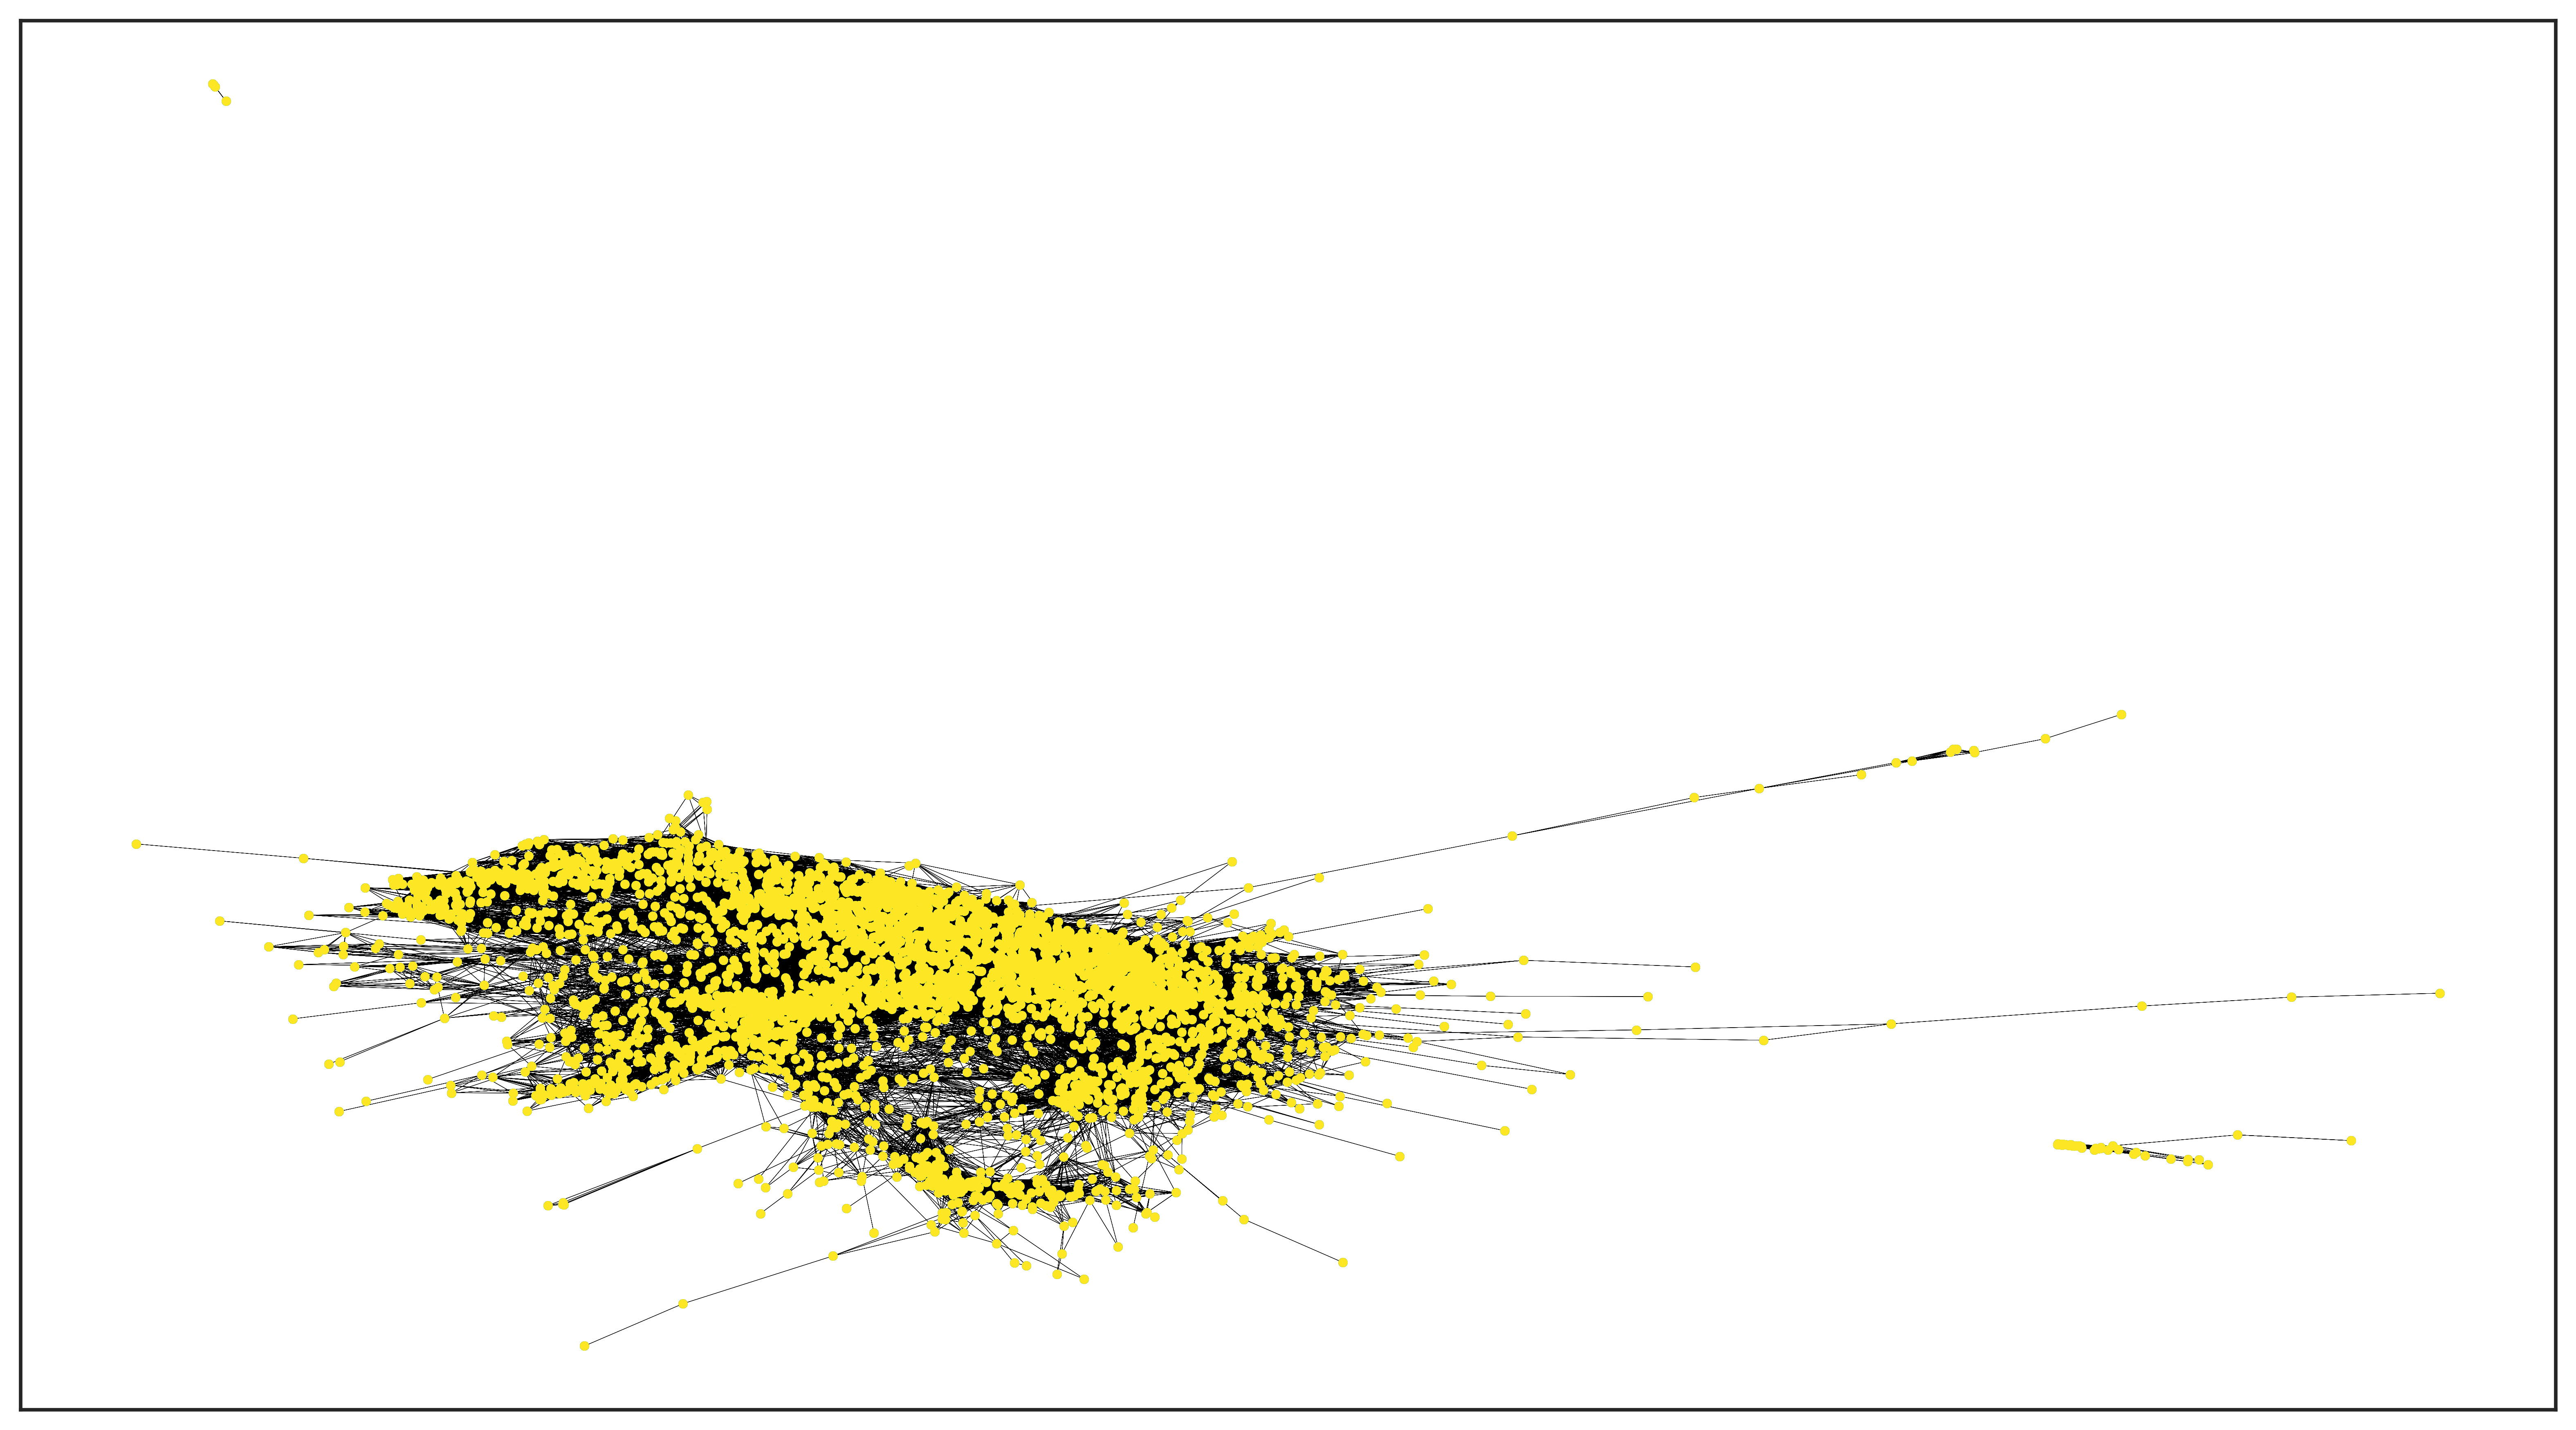

In [11]:
plt.rcParams['figure.dpi'] = 500

fig, ax = plt.subplots(1, figsize = (16,9))

count = 0.
for com, color in zip(set(louvian_mod_max.values()), colors1.colors):
    count += 1.
    list_nodes = [nodes for nodes in louvian_mod_max.keys()]
    nx.draw_networkx_nodes(G1, pos, list_nodes, node_size = 5, node_color = [color[:3]])
    nx.draw_networkx_edges(G1, pos, edge_color = 'black', alpha = 0.5, width = 0.1)
plt.show()